# Predict Survival on Titanic Datasets Using Classification Methods(Part 1)

## Introduction
One of the most famous shipwrecks in the history, the sinking of Titanic, is still often mentioned today. This great ship sank in the North Atlantic Ocean in the early morning of 15 April 1912, after it collided with an iceberg. This tragedy shocked the whole international community. There were more than 1500 people out of 2224 passengers and crew died in this tragedy. The RMS Titanic was the largest ship afloat at the time it entered service and was the second of three Olympic-class ocean liners operated by the White Star Line. The Titanic was built by the Harland and Wolff shipyard in Belfast. Thomas Andrews, her architect, died in the disaster.

In this notebook, we aim to provide multiple classification machine learning methods on Titanic train data, to predict whether a passenger would be survived on Titanic or not on the test dataset. The Machine learning tools include: Naive Bayes, Support Vector Machine(SVM), K-Nearest Neighbour(KNN), Decision Tree Classifier, Random Forest Classifier, AdaBoost Classifier, Gradient Boosting Classifier, Logistic Regression with Regularization(Ridge & LASSO).


## Part 1. Exploratory Data Analysis(EDA)

In this section, we will do data preprocessing, including data wrangling, data visualization, feature engineering and missing value processing, to explore and summarize the main characteristics of the Titanic dataset.
<img src = "EDA.png" width = 350>


### 1.0 Load Packages
We mainly use packages as follows:

In [233]:
import numpy as np 
import pandas as pd
from pandas import get_dummies
import re
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

### 1.1 Import the Dataset and Do Data Wrangling
To begin with, we first import the data, then apply function shape(), info() and isnull() to get a quick and dirty overview of the features. This step is a preparation for the feature engineering step, which can provide us some clues on the big picture of the project.

In [234]:
# Read the tables
Data = pd.read_csv("TitanicData/train.csv") 
Data_test = pd.read_csv("TitanicData/test.csv") 
Data_test_survive = pd.read_csv("TitanicData/gender_submission.csv") 
print('Type of data: ',type(Data))
print('------------------------------------------')
print('Dimension of train table: ',Data.shape)#891 x 12
print('Dimension of test table: ',Data_test.shape)#418 x 11
print('Dimension of gender_submission table: ',Data_test_survive.shape)#418 x 2
print('------------------------------------------')
print('train table summary: ',Data.info())
print('------------------------------------------')
print('test table summary: ',Data_test.info())
print('------------------------------------------')
print('gender_submission table summary: ',Data_test_survive.info())

Type of data:  <class 'pandas.core.frame.DataFrame'>
------------------------------------------
Dimension of train table:  (891, 12)
Dimension of test table:  (418, 11)
Dimension of gender_submission table:  (418, 2)
------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
train table summary:  None
------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns 

In [235]:
Data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [236]:
# Missing value summary
print('train Set NA: ')
print(Data.isnull().sum())
print('------------------------------------------')
print('test Set NA: ')
print(Data_test.isnull().sum())
print('------------------------------------------')
print('gender_submission NA: ')
print(Data_test_survive.isnull().sum())

train Set NA: 
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
------------------------------------------
test Set NA: 
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
------------------------------------------
gender_submission NA: 
PassengerId    0
Survived       0
dtype: int64


At a first glance, we find:

(1)There are some missing values in column 'Age' and 'Cabin' in both train and test table. Besides, there are 2 missing values in 'Embarked' column in train table and 1 missing value in 'Fare' in test table.

(2)There are 12 columns in the train table, 11 columns in the test table and 2 columns in the 'gender_submission' table. 'PassengerId' column appears in all three tables. The column 'Survived' in 'gender_submission' table is the target variable of test set and the columns in 'test' table are the predictor variables of test set.

Usually, we can use machine learning algorithms on train data and do the prediction and data evaluation on the test data. However, considering that there might be some potential information from 'Name' column, we need to split column 'Name' in both train and test datasets. So we plan to merge train and test set together and do spliting after data preprocessing.

In [237]:
# Data wrangling
titanic_test = pd.merge(Data_test, Data_test_survive, how ='outer', on = 'PassengerId')
print('Test Set Dimension: ',titanic_test.shape)

Test_Id = titanic_test['PassengerId']

Titanic0 = Data.append(titanic_test)
print('Whole Set Dimension: ',Titanic.shape)
print('------------------------------------------')
print(Titanic0.isnull().sum())

#cols = Titanic0.columns.tolist()
#cols.insert(0, cols.pop(cols.index('PassengerId')))
#Titanic = Titanic0.reindex(columns= cols)
Titanic0 = Titanic0.set_index('PassengerId')
Titanic0.head()

Test Set Dimension:  (418, 12)
Whole Set Dimension:  (1309, 9)
------------------------------------------
Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived          0
Ticket            0
dtype: int64


,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,
1,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0,A/5 21171
2,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1,PC 17599
3,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1,STON/O2. 3101282
4,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1,113803
5,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0,373450


### 1.2 Feature Engineering and Data visualzation
The whole dataset has 1309 rows, which equals to the sum of the rows from train set(891) and test set(418). It means no coincident passengerId in two sets. 

After simple data wrangling, let's take a look at the titanic table again. There are 12 columns in this table:
##### Target variable:
* Survived: Survived (1) or died (0)

##### Predictor variables:
* Cabin: Cabin number
* Embarked: Port of Embarkation(C = Cherbourg, Q = Queenstown, S = Southampton)
* Fare: Passenger fare
* Parch: # of parents / children aboard the Titanic
* Pclass: Ticket class(1 = 1st, 2 = 2nd, 3 = 3rd)
* SibSp: # of siblings / spouses aboard the Titanic
* Ticket: Ticket number

In this section, we plan to do the following steps:

(1) Split column 'Name' and extract a new column called 'Titles'. From the title column, we may get more information on the gender and age perspective

(2) Variable 'Ticket' and 'Cabin' are obviously unuseful, we remove them from the table

(3) Missing value processing

(4) Explore relationships between target variable and predictor variables using data visualization, get more useful information on how to deal with each type of features. 'Parch' and 'SibSp' can combine together, we will create a new column called 'FamNum' to show the number of family members aboard the Titanic


### 1.2.1 Extract Title column
Variable 'Name' has titles such as 'Mr.','Mrs.','Miss.','Master.'. Extract titles from passenger names may be helpful.

Title names:  ['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer' 'Dona']
------------------------------------------------------


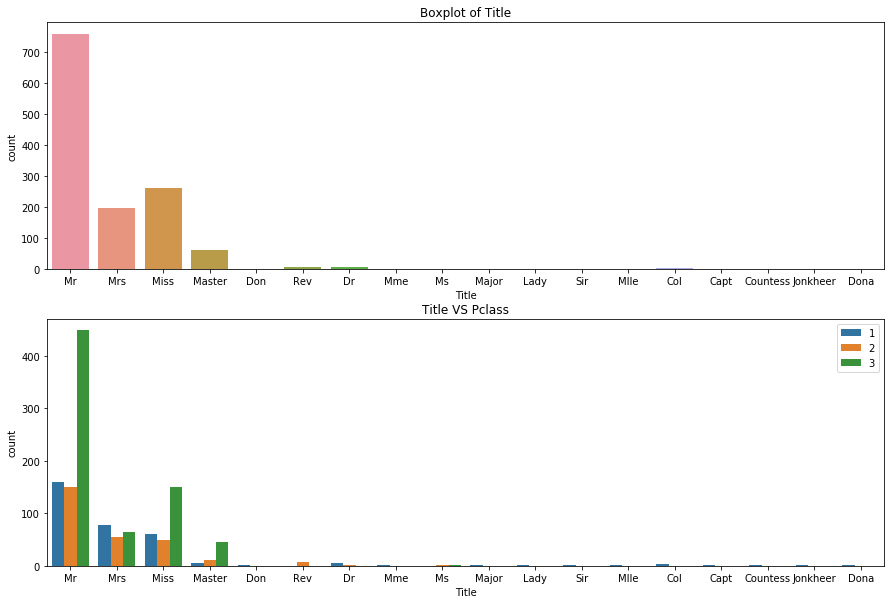

In [238]:
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
Titanic0['Title'] = Titanic0['Name'].apply(get_title)
print('Title names: ',Titanic0['Title'].unique())
print('------------------------------------------------------')

f,ax=plt.subplots(2,1,figsize=(15,10))
sns.countplot('Title',data=Titanic0,ax=ax[0])
ax[0].set_title('Boxplot of Title')
sns.countplot('Title',hue='Pclass',data=Titanic0,ax=ax[1])
plt.legend(loc='upper right')
ax[1].set_title('Title VS Pclass')
plt.show()

From the boxplot above, we find most passengers are called using 4 titles 'Mr' 'Mrs' 'Miss' 'Master', we consider to group all non-common titles into 'Others' group. Meanwhile, there are some synonyms, such as 'Ms' 'Miss' and 'Mme' are the same as 'Mrs'. we need to convert them into the same titles.

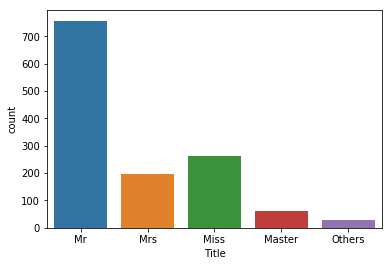

In [239]:
Titanic0['Title'] = Titanic0['Title'].replace(['Don','Rev','Dr','Major','Lady','Sir','Col','Capt','Countess','Jonkheer','Dona'], 'Others')
Titanic0['Title'] = Titanic0['Title'].replace('Mlle', 'Miss')
Titanic0['Title'] = Titanic0['Title'].replace('Ms', 'Miss')
Titanic0['Title'] = Titanic0['Title'].replace('Mme', 'Mrs')
sns.countplot('Title',data=Titanic0)

### 1.2.2 Remove unuseful variables

In [240]:
#print(Titanic0[['Cabin','Pclass','Fare']][Titanic0['Cabin'].notnull()].loc[Titanic0['Pclass'] == 1])
#print('-----------------------------------------------')
#print(Titanic0[['Cabin','Pclass','Fare']][Titanic0['Cabin'].notnull()].loc[Titanic0['Pclass'] == 2])
#print('-----------------------------------------------')
#print(Titanic0[['Cabin','Pclass','Fare']][Titanic0['Cabin'].notnull()].loc[Titanic0['Pclass'] == 3])
Titanic = Titanic0.drop(['Cabin','Ticket','Name'],axis = 1)
Titanic.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Title
PassengerId,,,,,,,,,
1,22.0,S,7.2500,0,3,male,1,0,Mr
2,38.0,C,71.2833,0,1,female,1,1,Mrs
3,26.0,S,7.9250,0,3,female,0,1,Miss
4,35.0,S,53.1000,0,1,female,1,1,Mrs
5,35.0,S,8.0500,0,3,male,0,0,Mr


OK, right now, Let's split Titanic data into training set and test set. Do all exploration on both sets, and do training on train set, comparing the models using evaluation results from test set.

In [241]:
#Testset = Titanic.loc[Titanic.index.isin(Test_Id.tolist())]
#Trainset = Titanic.loc[~Titanic.index.isin(Test_Id.tolist())]
#Testset.shape#418 10
#Trainset.shape#891 10
#Testset.head()

### 1.2.3 Missing Value Processing
In previous section, we detect that there are 177 missing values in column 'Age', 687 missing values in 'Cabin', 2 in 'Embarked' and 1 in 'Fare'. As we remove 'Cabin' from dataset, we just consider the NA problem on three features left. We have several methods to fix NA problem:

(1) Remove rows with NA: This method is not very effective, unless the tuple contains several attributes with missing values. By ignoring the tuple, we do not make use of the remaining attributes’ values in the tuple. 

(2) Fill in the missing value manually:
In general, this approach is time consuming and may not be feasible given a large data set with many missing values.

(3) Fill NA with some values, such as choosing mean, median, mode to fill in the blank: For normal (symmetric) data dis- tributions, the mean can be used, while skewed data distribution should employ the median

(4) Use the attribute mean or median for all samples belonging to the same class

(5) Determine missing value using ML tools such as regression and Bayesian inference: predict missing values with machine learning. https://stackoverflow.com/questions/40996051/predict-na-missing-values-with-machine-learning

Which method should we use? It depends. 

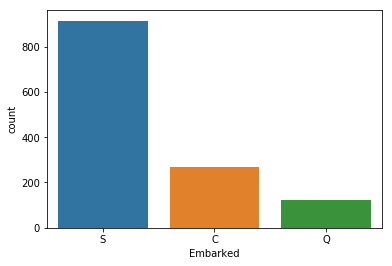

Because just 2 missing values in "Embarked" column, no matter what we fill the missing values, it will not occur big mistake. So we use the name of port which has the largest amount of passengers: Southampton(S) to fill in the blank
--------------------------------------
Number of NA now: 0


In [242]:
# For 'Embarked' column
f,ax=plt.subplots(figsize=(6,4))
sns.countplot('Embarked',data=Titanic)
plt.show()
print('Because just 2 missing values in "Embarked" column, no matter what we fill the missing values, it will not occur big mistake. So we use the name of port which has the largest amount of passengers: Southampton(S) to fill in the blank')
Titanic['Embarked'].fillna('S',inplace=True)
print('--------------------------------------')
print('Number of NA now:',Titanic["Embarked"].isnull().sum())

Just 1 missing value in "Fare" column.  After checking the histogram, we find a right-skewness. To fill in blank, using median seems to be a good idea
--------------------------------------
Number of NA now: 0


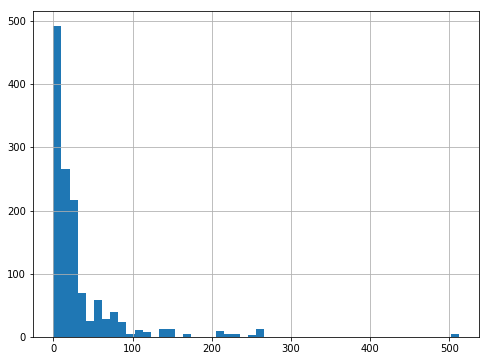

In [243]:
# For 'Fare' column
Titanic['Fare'].hist(bins = 50,figsize=(8,6))
print('Just 1 missing value in "Fare" column.  After checking the histogram, we find a right-skewness. To fill in blank, using median seems to be a good idea')
Titanic["Fare"].fillna(Titanic["Fare"].median(), inplace=True)
print('--------------------------------------')
print('Number of NA now:',Titanic["Fare"].isnull().sum())

There are 177 missing values in Age column, it is not a small number. We cannot simply remove these rows. Let's check histogram first. The histogram is a little right-skewed, we can use three different methods to fill the blank:

(1)First Method: Fill in blank with Median value

(2)Second Method: Fill in blank with Median value for all samples belonging to the same class

(3)Third Method: Fill in blank with prediction using ML tools such as random forest regressor

In the third method, we plan to use the rows without NA as trainset and validation set and apply 10-Fold CV random forest regression on them, then use the rows with NA to do prediction. This method will help us fill the blank better. However, Data leakage is a big concern. We need to exclude 'Survived' column when we do modeling on training and validation set. 

Note: More specific details of decision tree and random forest regression will be introduced in House Price Prediction project. If you are interested in K-fold CV Random forest, please see the link: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [247]:
# For 'Age' column

print('Number of NA from Original Titanic Data:',Titanic["Age"].isnull().sum())
print('---------------------------------------------------------------')

print("First Method: Fill in blank with Median value" )
Titanic1 = Titanic.copy()
Titanic1["Age"].fillna(Titanic1["Age"].median(), inplace=True)
print('Number of NA after Method1:',Titanic1["Age"].isnull().sum())
print('---------------------------------------------------------------')

print("Second Method: Fill in blank with Median value for all samples belonging to the same class" )
print('lets check the average age by',Titanic.groupby('Title')['Age'].mean())
Titanic2 = Titanic.copy()
Titanic2.loc[(Titanic2.Age.isnull())&(Titanic2.Title=='Mr'),'Age']=32
Titanic2.loc[(Titanic2.Age.isnull())&(Titanic2.Title=='Mrs'),'Age']=37
Titanic2.loc[(Titanic2.Age.isnull())&(Titanic2.Title=='Master'),'Age']=5
Titanic2.loc[(Titanic2.Age.isnull())&(Titanic2.Title=='Miss'),'Age']=22
Titanic2.loc[(Titanic2.Age.isnull())&(Titanic2.Title=='Others'),'Age']=45
print('Number of NA after Method 2 :',Titanic2["Age"].isnull().sum())
print('---------------------------------------------------------------')

print("Third Method: Fill in blank with prediction using ML tools such as random forest regressor" )

Number of NA from Original Titanic Data: 263
---------------------------------------------------------------
First Method: Fill in blank with Median value
Number of NA after Method1: 0
---------------------------------------------------------------
Second Method: Fill in blank with Median value for all samples belonging to the same class
lets check the average age by Title
Master     5.482642
Miss      21.824366
Mr        32.252151
Mrs       36.918129
Others    45.178571
Name: Age, dtype: float64
Number of NA after Method 2 : 0
---------------------------------------------------------------
Third Method: Fill in blank with prediction using ML tools such as random forest regressor


In [245]:
Titanic3 = Titanic.copy()
Titanic3.loc[Titanic3.Title=='Mr','Title'] = '0'
Titanic3.loc[Titanic3.Title=='Mrs','Title']= '1'
Titanic3.loc[Titanic3.Title=='Master','Title']= '2'
Titanic3.loc[Titanic3.Title=='Miss','Title']= '3'
Titanic3.loc[Titanic3.Title=='Others','Title']= '4'
Titanic3.loc[Titanic3.Sex=='male','Sex']= '0'
Titanic3.loc[Titanic3.Sex=='female','Sex']= '1'
Titanic3.loc[Titanic3.Embarked=='C','Embarked']= '0'
Titanic3.loc[Titanic3.Embarked=='Q','Embarked']= '1'
Titanic3.loc[Titanic3.Embarked=='S','Embarked']= '2'

Titanic3['Title'] = [int(x) for x in Titanic3['Title']]
Titanic3['Sex'] = [int(x) for x in Titanic3['Sex']]
Titanic3['Embarked'] = [int(x) for x in Titanic3['Embarked']]

Titanic3['Title'] = Titanic3['Title'].astype('category',ordered=False)
Titanic3['Sex'] = Titanic3['Sex'].astype('category',ordered=False)
Titanic3['Embarked'] = Titanic3['Embarked'].astype('category',ordered=False)
Titanic3['Pclass'] = Titanic3['Pclass'].astype('category',ordered=True)

Train_3 = Titanic3.loc[Titanic3['Age'].notnull()]
Test_3 = Titanic3.loc[Titanic3['Age'].isnull()]#263 9
NanRows = Train_3.index.tolist()#263

#Train_3_t, Train_3_v = train_test_split(Train_3, random_state=0,train_size = 0.8)
#Train_3_t_X = Train_3_t[['Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp','Survived', 'Title']]
#Train_3_t_y = Train_3_t['Age']
#Train_3_v_X = Train_3_v[['Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp','Survived', 'Title']]
#Train_3_v_y = Train_3_v['Age']
Train_3_X = Train_3[['Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Title']]
Train_3_y = Train_3['Age']
Test_3_X = Test_3[['Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Title']]
Test_3_y = Test_3['Age']

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.metrics import mean_squared_error

# First create the base model to tune
rf = RandomForestRegressor()
print('Parameters currently in use:\n')
print(pprint(rf.get_params()))
# Tuning Random Hyperparameter
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 2, stop = 302, num = 5)]
# Method of selecting samples for training each tree
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,'bootstrap': bootstrap}
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, random_state=0, cv = 5, verbose=2, n_jobs = -1)

# fit the model
rf_random.fit(Train_3_X, Train_3_y)
print('Optimal parameters: ',rf_random.best_params_)

pred = rf_random.predict(Test_3_X)

Test_3['Pred'] = pred
Test_3 = Test_3.drop('Age',axis = 1)
Test_3 = Test_3.rename(columns = {'Pred':'Age'})

Titanic4 = Train_3.append(Test_3)
print('Number of NA after Method 3:',Titanic4["Age"].isnull().sum())
print('-------------------------------------------------------')

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
None
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=2, bootstrap=True ..................................
[CV] n_estimators=2, bootstrap=True ..................................
[CV] n_estimators=2, bootstrap=True ..................................
[CV] ................... n_estimators=2, bootstrap=True, total=   0.0s
[CV] n_estimators=2, bootstrap=True ..................................
[CV] n_estimators=2, bootstrap=True ..................................
[CV] ................... n_estimators=2, bootstrap=True, total=   0.1s
[CV] ................... n_estimators

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.1s finished


Optimal parameters:  {'n_estimators': 227, 'bootstrap': True}
Number of NA after Method 3: 0
-------------------------------------------------------


/Users/eluo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


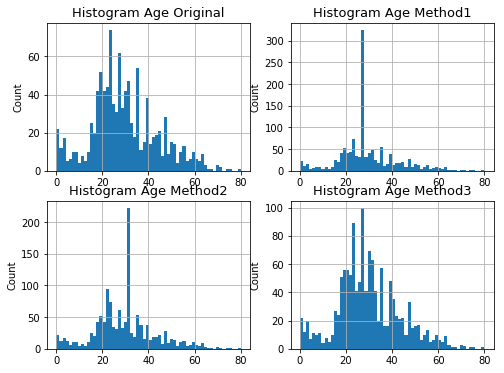

In [249]:
f,ax = plt.subplots(2,2,figsize=(20,15))
Titanic['Age'].hist(bins = 60,figsize=(8,6),ax = ax[0][0])
ax[0,0].set_title('Histogram Age Original',fontsize=13)
ax[0,0].set_ylabel('Count')

Titanic1['Age'].hist(bins = 60,figsize=(8,6),ax = ax[0,1])
ax[0,1].set_title('Histogram Age Method1',fontsize=13)
ax[0,1].set_ylabel('Count')

Titanic2['Age'].hist(bins = 60,figsize=(8,6),ax = ax[1,0])
ax[1,0].set_title('Histogram Age Method2',fontsize=13)
ax[1,0].set_ylabel('Count')

Titanic4['Age'].hist(bins = 60,figsize=(8,6),ax = ax[1][1])
ax[1,1].set_title('Histogram Age Method3',fontsize=13)
ax[1,1].set_ylabel('Count')

plt.show()

Comparing the original histogram and three filling methods, we prefer the last one. Intutively, to fill in the missing value of one record, the best way is to find the similar records. Here we implement the random forest regression model to predict missing values using the 'similar' records, the values of prediction makes more sense than median value.

In following sections, we will notice the strings from column 'Title', 'Sex' and 'Embarked' are rewrited using integers. Just remember:

For 'Title', 0: 'Mr'  1:'Mrs'  2:'Master'  3:'Miss'  4:'Others'

For 'Sex', 0:'male'  1:'female'

For 'Embarked', 0:'C'  1:'Q'  2:'S'

### 1.2.4 Explore data using data visualization

Titanic tragedy is one of the deadiest sinking disaster in our history. Looking at the pie plot of 'Survived' column from whole dataset, train and test set, we can see: Just 37.7% of passengers survived in the whole set, 38.4% in train set and 36.4% in test set.

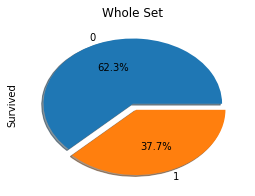

In [250]:
#f,ax=plt.subplots(1,3,figsize=(15,3))
f,ax=plt.subplots(figsize=(4,3))
#Titanic['Survived'].value_counts().plot.pie(explode=[0,0.1],ax = ax[0],autopct='%1.1f%%',shadow=True)
Titanic4['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',shadow=True)
#ax[0].set_title('Whole Set')
ax.set_title('Whole Set')
#Trainset['Survived'].value_counts().plot.pie(explode=[0,0.1],ax = ax[1],autopct='%1.1f%%',shadow=True)
#ax[1].set_title('Train Set')
#Testset['Survived'].value_counts().plot.pie(explode=[0,0.1],ax = ax[2],autopct='%1.1f%%',shadow=True)
#ax[2].set_title('Test Set')
plt.show()

It is evident that not many passengers survived the accident. We need to dig down more to get better insights from the data and see which categories of the passengers did survive and who didn't. We will try to check the survival rate by using the different features of the dataset. Some of the features being Sex, Port Of Embarcation, Age,etc. We plan to deal with them based on different feature types: continuous, ordinary or categorical.

#### Categorical Features: 
These features have several categories, we cannot sort the categories by deciding which category is larger/better than others. 'Sex','Title','Embarked' are categorical features obviously. 

#### Continuous Features: 
A feature is said to be continous if it can take values between any two points or between the minimum or maximum values in the features column, such as 'Age' 

#### Ordinary Features: 
There are several categories which can be sorted, for example 'Pclass'.

Let's create some plots to show which kind of passengers will have more opportunity to survive in this horrible disaster.

No handles with labels found to put in legend.


Contigency Table Survived VS Sex Whole Dataset
Survived    0    1
Sex               
0         734  109
1          81  385
----------------------------------------------


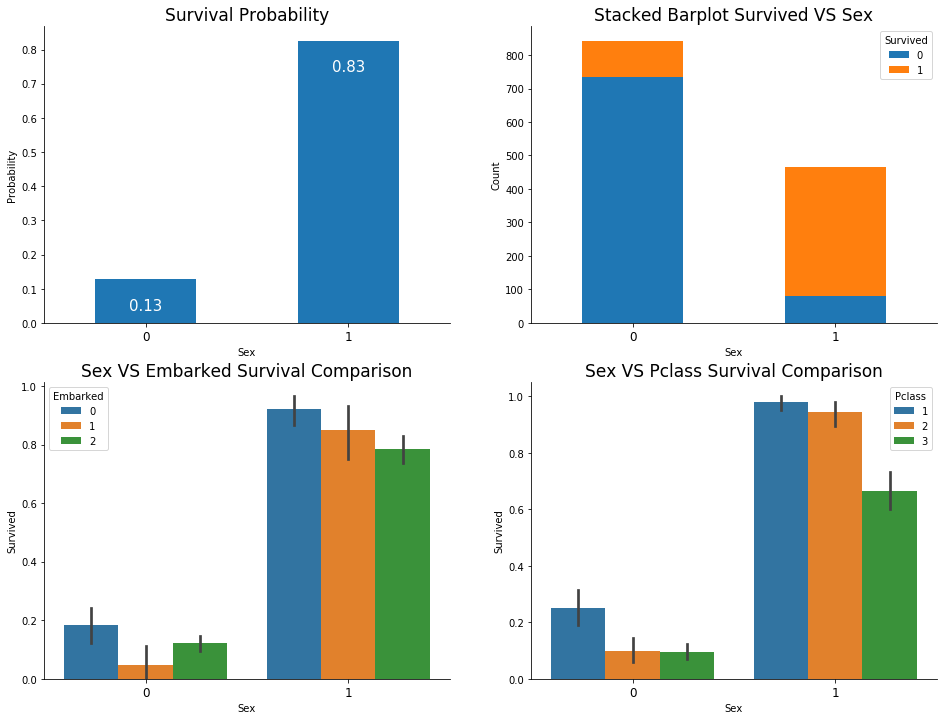

In [255]:
# Categorical Features: Sex
print('Contigency Table Survived VS Sex Whole Dataset')
SuvVSSex = pd.crosstab(Titanic4['Sex'],Titanic4['Survived'])
print(SuvVSSex)
Prob = Titanic4[['Sex','Survived']].groupby('Sex').mean()
print('----------------------------------------------')

f,ax=plt.subplots(2,2,figsize=(16,12))
Prob.plot.bar(ax = ax[0,0])
ax[0,0].set_title('Survival Probability',fontsize=17)
ax[0,0].set_ylabel('Probability')
ax[0,0].set_xlabel('Sex')
rects = ax[0,0].patches
labels0 = Prob['Survived'].tolist()
labels1 = [ '%.2f' % elem for elem in labels0 ]
labels = [float(elem) for elem in labels1 ]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax[0,0].text(rect.get_x() + rect.get_width() / 2, height-0.1, 
                 label,ha='center', va='bottom',fontsize=15,color = 'white')
ax[0,0].get_legend().remove()

SuvVSSex.plot.bar(stacked=True,ax = ax[0,1])
plt.legend(loc = 2)
ax[0,1].set_title('Stacked Barplot Survived VS Sex',fontsize=17)
ax[0,1].set_ylabel('Count')
ax[0,1].set_xlabel('Sex')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Embarked', data=Titanic4, ax = ax[1,0])
ax[1,0].set_title('Sex VS Embarked Survival Comparison',fontsize = 17)

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Pclass', data=Titanic4, ax  = ax[1,1])
ax[1,1].set_title('Sex VS Pclass Survival Comparison',fontsize = 17)

for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=0,fontsize = 12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.show()

In [254]:
print('Sex vs Embarked Survival Contigency Table')
Table1 = pd.crosstab([Titanic4.Sex,Titanic.Survived],
                     [Titanic4.Embarked],margins=True)
display(Table1.style.background_gradient(cmap='summer_r'))
print('----------------------------------------------')
print('Sex vs Pclass Survival Contigency Table')
Table2 = pd.crosstab([Titanic4.Sex,Titanic.Survived],
                     [Titanic4.Pclass],margins=True)
display(Table2.style.background_gradient(cmap='summer_r'))
# from IPython.display import display_html
# def display_side_by_side(*args):
#    html_str=''
#    for df in args:
#        html_str+=df.to_html()
#    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
# display_side_by_side(Table1,Table2)

Sex vs Embarked Survival Contigency Table


----------------------------------------------
Sex vs Pclass Survival Contigency Table


From the Contigency table and plots shown above, we have some interesting discoveries:

1. 'Gender' really matters! 

Number of men is almost twice the number of women, however, the number of men saved is just one third of women saved. The percentage of survived women is 83% among all women, but the percentage of survived men is pretty low, just 13% male were saved. The result shows that gentlemen in Titanic complied with the 'Ladies first' rule at the most critical juncture, most of them sacrificed themselves and gave the living opportunities to women.

2. 'Lady first' principle is also corret no matter which port are you from(Embarked) and whether you are rich or not(Pclass)

From plot 3 and plot 4 we can see, Survival probability of female is much higher than male. Survival probability of men from Queenstown is the lowest, less than 10% of them were saved. But men from Southampton have the largest number if death, 546, almost half people in Titanic. That's horrible:(

3. 'Money is important'

Men from second class have the largest number of death among all people. Even though gender matthers, the survival probability of third-class female is not as high as other two classes, just around 65%. Why this happened? We will explore the reason later

In [256]:
Titanic4.head(10)

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Title
PassengerId,,,,,,,,,
1,22.0,2,7.2500,0,3,0,1,0,0
2,38.0,0,71.2833,0,1,1,1,1,1
3,26.0,2,7.9250,0,3,1,0,1,3
4,35.0,2,53.1000,0,1,1,1,1,1
5,35.0,2,8.0500,0,3,0,0,0,0
7,54.0,2,51.8625,0,1,0,0,0,0
8,2.0,2,21.0750,1,3,0,3,0,2
9,27.0,2,11.1333,2,3,1,0,1,1
10,14.0,0,30.0708,0,2,1,1,1,1


In [258]:
Titanic4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 9 columns):
Age         1309 non-null float64
Embarked    1309 non-null category
Fare        1309 non-null float64
Parch       1309 non-null int64
Pclass      1309 non-null category
Sex         1309 non-null category
SibSp       1309 non-null int64
Survived    1309 non-null int64
Title       1309 non-null category
dtypes: category(4), float64(2), int64(3)
memory usage: 107.0 KB


In [229]:
#Titanic.plot(kind='box', subplots=True, layout=(2,4), sharex=False, sharey=False, figsize=(10,8))
#plt.figure()